In [122]:
#def main_function(test_year):

# The rest of your script can go here

In [123]:
!pip install pybaseball

In [124]:
!pip install --upgrade scikit-learn imbalanced-learn

In [125]:
!pip install featureranker

In [126]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os

from featureranker.utils import view_data
from featureranker.rankers import classification_ranking
from featureranker.rankers import voting
# from featureranker import view_data
# from featureranker import classification_hyper_param_search
# from featureranker import classification_ranking
# from featureranker import voting
# from featureranker import plot_ranking


import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

# Seed value
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. Depending on whether you are using CUDA
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

# 6. Configure a new global `torch` default floating point tensor type
# (optional, if you are using PyTorch)
torch.set_default_tensor_type('torch.FloatTensor')

# 7. For `torch.backends.cudnn`
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# import pycuda.autoinit
# import pycuda.gpuarray as gpuarray
pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()
torch.cuda.empty_cache()

In [127]:
import os
import sys

# Check if the code is running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    save_path='/content/drive/My Drive/baseball_pred/pybaseball_v3_saved'
    #Vegas Odds path
    vegas_betting_paths='/content/drive/My Drive/baseball_pred/betting_odds/'
    vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

    #Scrambled Odds path
    scrambled_betting_paths='/content/drive/My Drive/baseball_pred/all_money_lines.csv'


    #Per_game_data path
    per_game_path='/content/drive/My Drive/baseball_pred/pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



    milb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
    milb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
    mlb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
    mlb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
    scoring_full_all_years='/content/drive/My Drive/baseball_pred/scoring_full_all_years.pkl'
    scoring_save_path='/content/drive/My Drive/baseball_pred/scoring_milb.pkl'
    def save_results_format(year):
      save_results=f'/content/drive/My Drive/baseball_pred/results/better_data_{year}.xlsx'
      return save_results
else:
    # Code to run if not in Google Colab
    # For example, set a local path for your files if on a local machine
    # local_drive_path = 'd:/Users/vile3/Google Drive'
    # if not os.path.exists(local_drive_path):
        # os.makedirs(local_drive_path)
        save_path='pybaseball_v3_saved'
        vegas_betting_paths='./betting_odds/'
        vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

        #Scrambled Odds path
        scrambled_betting_paths='all_money_lines.csv'


        #Per_game_data path
        per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



        milb_batter_path = './SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
        milb_pitcher_path = './SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
        mlb_batter_path = './SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
        mlb_pitcher_path = './SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
        scoring_full_all_years='scoring_full_all_years.pkl'
        scoring_save_path='scoring_milb.pkl'
        def save_results_format(year):
          save_results=f'./results/better_data_{year}.xlsx'
          return save_results
    # Now you can use local_drive_path as the base path for your file operations


# Functions

In [128]:
# Check if CUDA is available

# Move your model to the GPU
# model = model.to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# When you load your data, move it to the GPU
# Assume inputs and labels are your input data and labels
# inputs, labels = inputs.to(device), labels.to(device)


# Neural Network

In [129]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data using .iloc for position-based indexing
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

#CALL THE MODEL
# def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, patience=5, num_epochs=50):
#     best_loss = float('inf')
#     patience_counter = 0
#     best_model_path = 'best_model.pth'  # File path for saving the best model

#     for epoch in range(num_epochs):  # number of epochs
#         model.train()
#         train_losses = []
#         for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels.squeeze())
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         avg_train_loss = np.mean(train_losses)
#         print(f'Training Loss: {avg_train_loss}')

#         model.eval()
#         valid_losses = []
#         with torch.no_grad():
#             for inputs, labels in test_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels.squeeze())
#                 valid_losses.append(loss.item())

#         avg_valid_loss = np.mean(valid_losses)
#         print(f'Validation Loss: {avg_valid_loss}')

#         # Save the model at each epoch
#         epoch_model_path = f'model_epoch_{epoch + 1}.pth'
#         torch.save(model.state_dict(), epoch_model_path)

#         # Update the best model if validation loss improves
#         if avg_valid_loss < best_loss:
#             best_loss = avg_valid_loss
#             torch.save(model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print('Early stopping triggered')
#                 break

#     # Load the best model
#     model.load_state_dict(torch.load(best_model_path))

#     # Evaluate the best model
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate confusion matrix and classification report
#     conf_matrix = confusion_matrix(all_labels, all_preds)
#     class_report = classification_report(all_labels, all_preds,output_dict=True)
#     print('Confusion Matrix:')
#     print(conf_matrix)
#     print('Classification Report:')
#     print(class_report)
#     return conf_matrix, class_report

# def train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience=5, num_epochs=50):
#     best_loss = float('inf')
#     patience_counter = 0
#     best_model_path = 'best_model.pth'  # File path for saving the best model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)  # Move the model to the appropriate device

#     for epoch in range(num_epochs):  # number of epochs
#         model.train()
#         train_losses = []
#         for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
#             inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels.squeeze())
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         avg_train_loss = np.mean(train_losses)
#         print(f'Training Loss: {avg_train_loss}')

#         model.eval()
#         valid_losses = []
#         with torch.no_grad():
#             for inputs, labels in val_loader:  # Use validation data for validation
#                 inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels.squeeze())
#                 valid_losses.append(loss.item())

#         avg_valid_loss = np.mean(valid_losses)
#         print(f'Validation Loss: {avg_valid_loss}')

#         # Save the model at each epoch
#         epoch_model_path = f'model_epoch_{epoch + 1}.pth'
#         torch.save(model.state_dict(), epoch_model_path)

#         # Update the best model if validation loss improves
#         if avg_valid_loss < best_loss:
#             best_loss = avg_valid_loss
#             torch.save(model.state_dict(), best_model_path)
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print('Early stopping triggered')
#                 break

#     # Load the best model
#     model.load_state_dict(torch.load(best_model_path, map_location=device))
#     model.load_state_dict(torch.load(best_model_path))

#     # Evaluate the best model
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:  # Use test data for final evaluation
#             inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     # Calculate confusion matrix and classification report
#     conf_matrix = confusion_matrix(all_labels, all_preds)
#     class_report = classification_report(all_labels, all_preds, output_dict=True)
#     print('Confusion Matrix:')
#     print(conf_matrix)
#     print('Classification Report:')
#     print(class_report)
#     return conf_matrix, class_report


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, patience=5, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model
    val_losses_per_epoch = []
    # global label1,label2, label3, label4, label5, label6,model1, model2, model3, model_all
    for param in model.parameters():
        model_all=(param.device)
    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            # label1=(inputs.device)
            # label2=(labels.device)
            # model1=(next(model.parameters()).device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:  # Use validation data for validation
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
                # label3=(inputs.device)
                # label4=(labels.device)
                # model2=(next(model.parameters()).device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())

                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        scheduler.step(avg_valid_loss)
        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    # model.load_state_dict(torch.load(best_model_path))
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:  # Use test data for final evaluation
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            # label5=(inputs.device)
            # label6=(labels.device)
            # model3=(next(model.parameters()).device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds,output_dict=True)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    return conf_matrix, class_report

import os

def save_to_path(df, filename, folder=save_path):
    if not os.path.exists(folder):
        os.makedirs(folder)

    path = os.path.join(folder, f'{filename}.csv')

    if os.path.exists(path):
        print(f'File {path} already exists.')
    else:
        df.to_csv(path, index=True)
        print(f'{filename} saved to {path}')

def process_per_game_data(per_game_data, columns_to_keep, train_years):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_Number'] = per_game_data.groupby(['Date', 'HmTm', 'VisTm']).cumcount() + 1
    per_game_data['Game_ID'] = (
        per_game_data['Date'].astype(str) +
        per_game_data['HmTm'] +
        per_game_data['VisTm'] +
        per_game_data['Game_Number'].astype(str)
    )
    # Set the index to 'DateHmTmVisTm'
    # Reset the current index
    per_game_data = per_game_data.reset_index()
    # Set the new index
    per_game_data.set_index('Game_ID', inplace=True)
    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]
    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)

    # Truncate rows based on the lowest train year
    lowest_train_year = min(train_years)
    per_game_data = per_game_data[per_game_data.index.str[:4] >= lowest_train_year]

    return per_game_data

def process_vegas_odds(paths):

    xlsx_dataframes = []
    for i, path in enumerate(paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)

    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects')

    xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
    home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
    visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

    home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
    visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

    # Merge on 'date'
    xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
    xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
    xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
    xlsx_dataframes['Game_Number'] = xlsx_dataframes.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    xlsx_dataframes['Game_ID'] = (
        xlsx_dataframes['date'].astype(str) +
        xlsx_dataframes['home_team'] +
        xlsx_dataframes['visiting_team'] +
        xlsx_dataframes['Game_Number'].astype(str)
    )

    xlsx_dataframes.set_index('Game_ID', inplace=True)

    xlsx_dataframes.drop(['Game_Number','date','home_team','visiting_team'], axis=1, inplace=True)
    print(xlsx_dataframes)

    return xlsx_dataframes

import time
from requests.exceptions import RequestException

def fetch_data_with_retry(fetch_func, data_type, max_retries=5, retry_delay=3):
    retries = 0
    while retries < max_retries:
        try:
            data = fetch_func(True)
            print(f"{data_type} data fetched successfully.")
            return data
        except RequestException as e:
            retries += 1
            print(f"Attempt {retries} failed with error: {e}. Retrying after {retry_delay} seconds...")
            time.sleep(retry_delay)
            retry_delay *= 2  # Exponential backoff
    print(f"Failed to fetch {data_type} data after {max_retries} attempts.")
    return None

def process_scrambled_odds(df):
    df['Game_Number'] = df.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    df['Game_ID'] = (
        df['date'].astype(str) +
        df['home_team'] +
        df['visiting_team'] +
        df['Game_Number'].astype(str)
    )

    df.set_index('Game_ID', inplace=True)

    # Fix: Correct the drop method usage by specifying the column indices correctly
    columns_to_drop = df.columns[[0, 1]]
    print("Dropping columns:", columns_to_drop)
    df = df.drop(columns=columns_to_drop)
    return df

def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]
def weighted_average(group, weights):
    return pd.Series(
        {col: np.average(group[col], weights=weights.loc[group.index]) for col in group.columns}
    )


# def replace_player_ids_with_stats(per_game_data, player_data, player_id_columns):
#     # Calculate averages
#     player_avg = player_data.groupby(player_data.index).mean()

#     # Create a dictionary for each stat
#     stat_dicts = {stat: player_avg[stat].to_dict() for stat in player_avg.columns}

#     for column in player_id_columns:
#         # Replace the player_IDs in the column with the stats
#         for stat, stat_dict in stat_dicts.items():
#             per_game_data[column + '_' + stat] = per_game_data[column].map(stat_dict)

#         # Drop the original player_ID column
#         per_game_data.drop(column, axis=1, inplace=True)

#     return per_game_data

# def replace_player_ids_with_stats(per_game_data, player_data, player_id_columns):
#     # Calculate averages
#     # player_avg = player_data.groupby(player_data.index).mean()
#     player_avg = player_data
#     # Create a dictionary for each stat
#     stat_dicts = {stat: player_avg[stat].to_dict() for stat in player_avg.columns}

#     # Initialize a dictionary to log missing player IDs with Game_ID
#     missing_player_ids = {}

#     for column in player_id_columns:
#         # Replace the player_IDs in the column with the stats
#         for stat, stat_dict in stat_dicts.items():
#             # Create a new column for each stat
#             new_column_name = column + '_' + stat
#             # Map player IDs to stats, log missing IDs
#             per_game_data[new_column_name] = per_game_data[column].apply(
#                 lambda x: stat_dict.get(x, float('nan'))
#             )
#             # Find missing player IDs and their Game_ID
#             missing_ids = per_game_data[per_game_data[new_column_name].isna()][column].unique()
#             for missing_id in missing_ids:
#                 if missing_id not in missing_player_ids:
#                     missing_player_ids[missing_id] = []
#                 missing_player_ids[missing_id].extend(
#                     per_game_data[per_game_data[column] == missing_id].index.tolist()
#                 )

#         # Drop the original player_ID column
#         per_game_data.drop(column, axis=1, inplace=True)

#     # Remove duplicates from the Game_ID lists
#     for player_id, game_ids in missing_player_ids.items():
#         missing_player_ids[player_id] = list(set(game_ids))

#     # Return the modified DataFrame and the dictionary of missing player IDs with Game_ID
#     return per_game_data, missing_player_ids


# def replace_player_ids_with_stats(per_game_data, player_stats_dicts, player_id_columns):
#     # Initialize a dictionary to log missing player IDs with Game_ID
#     missing_player_ids = {}

#     for column in player_id_columns:
#         # Replace the player_IDs in the column with the stats from the pre-made dictionaries
#         for stat, stat_dict in player_stats_dicts.items():
#             # Create a new column for each stat
#             new_column_name = column + '_' + stat
#             # Map player IDs to stats, log missing IDs
#             per_game_data[new_column_name] = per_game_data[column].apply(
#                 lambda x: stat_dict.get(x, float('nan'))
#             )
#             # Find missing player IDs and their Game_ID
#             missing_ids = per_game_data[per_game_data[new_column_name].isna()][column].unique()
#             for missing_id in missing_ids:
#                 if missing_id not in missing_player_ids:
#                     missing_player_ids[missing_id] = []
#                 missing_player_ids[missing_id].extend(
#                     per_game_data[per_game_data[column] == missing_id].index.tolist()
#                 )

#         # Drop the original player_ID column
#         per_game_data.drop(column, axis=1, inplace=True)

#     # Remove duplicates from the Game_ID lists
#     for player_id, game_ids in missing_player_ids.items():
#         missing_player_ids[player_id] = list(set(game_ids))

#     # Return the modified DataFrame and the dictionary of missing player IDs with Game_ID
#     return per_game_data, missing_player_ids


def replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dicts):
    missing_player_ids = {}

    for column in player_id_columns:
        player_type = 'pitcher' if 'PchID' in column else 'batter'
        player_data_dict = player_data_dicts[player_type]

        # Map player IDs to stats
        per_game_data[column] = per_game_data[column].map(player_data_dict)

        # Split the stats dictionary into separate columns
        stats_df = per_game_data[column].apply(pd.Series)
        stats_df.columns = [f"{column}_{col}" for col in stats_df.columns]

        # Concatenate the original DataFrame with the new columns
        per_game_data = pd.concat([per_game_data, stats_df], axis=1)

        # Check for missing player IDs
        missing_ids = per_game_data[per_game_data[column].isna()].index.unique()
        for missing_id in missing_ids:
            if missing_id not in missing_player_ids:
                missing_player_ids[missing_id] = []
            missing_player_ids[missing_id].extend(
                per_game_data[per_game_data[column] == missing_id].index.tolist()
            )

        # Drop the original player_ID column
        per_game_data.drop(column, axis=1, inplace=True)

    # Remove duplicates from the Game_ID lists and sort them
    for player_id, game_ids in missing_player_ids.items():
        missing_player_ids[player_id] = sorted(set(game_ids))

    return per_game_data, missing_player_ids

# def replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dicts):
#     missing_player_ids = {}

#     for column in player_id_columns:
#         # Determine if the column is for a pitcher or batter based on the prefix
#         player_type = 'pitcher' if 'PchID' in column else 'batter'
#         player_data_dict = player_data_dicts[player_type]

#         # Create new columns for each stat in the player's data dictionary
#         for stat in player_data_dict[next(iter(player_data_dict))].keys():
#             new_column_name = f"{column}_{stat}"
#             per_game_data[new_column_name] = per_game_data[column].map(
#                 lambda x: player_data_dict.get(x, {}).get(stat, float('nan'))
#             )

#             # Check for missing player IDs
#             missing_ids = per_game_data[per_game_data[new_column_name].isna()][column].dropna().unique()
#             for missing_id in missing_ids:
#                 if missing_id not in missing_player_ids:
#                     missing_player_ids[missing_id] = []
#                 missing_player_ids[missing_id].extend(
#                     per_game_data[per_game_data[column] == missing_id].index.tolist()
#                 )

#         # Drop the original player_ID column
#         per_game_data.drop(column, axis=1, inplace=True)

#     # Remove duplicates from the Game_ID lists and sort them
#     for player_id, game_ids in missing_player_ids.items():
#         missing_player_ids[player_id] = sorted(set(game_ids))

#     return per_game_data, missing_player_ids



# Assuming pitcher_data_dict and batter_data_dict are your dictionaries with player stats
# Call the function for pitchers and batters separately


# def replace_player_ids_with_stats(per_game_data, player_data_dict, player_id_columns):
#     # Convert player data dictionary into a DataFrame
#     player_stats_df = pd.DataFrame.from_dict(player_data_dict, orient='index').reset_index()
#     player_stats_df.rename(columns={'index': 'player_ID'}, inplace=True)

#     # Initialize a dictionary to log missing player IDs with Game_ID
#     missing_player_ids = {}

#     for column in player_id_columns:
#         # Merge the player stats DataFrame with the per_game_data on the player ID column
#         merged_data = per_game_data.merge(player_stats_df, left_on=column, right_on='player_ID', how='left', suffixes=('', f'_{column}'))

#         # Find missing player IDs and their Game_ID
#         missing_ids = merged_data[merged_data['player_ID'].isna()][column].unique()
#         for missing_id in missing_ids:
#             if missing_id not in missing_player_ids:
#                 missing_player_ids[missing_id] = []
#             missing_player_ids[missing_id].extend(
#                 merged_data[merged_data[column] == missing_id].index.tolist()
#             )

#         # Drop the original player_ID column and the temporary 'player_ID' column from the merge
#         per_game_data = merged_data.drop(columns=[column, 'player_ID'])

#     # Remove duplicates from the Game_ID lists
#     for player_id, game_ids in missing_player_ids.items():
#         missing_player_ids[player_id] = list(set(game_ids))

#     # Return the modified DataFrame and the dictionary of missing player IDs with Game_ID
#     return per_game_data, missing_player_ids

# Usage example:
# Assuming 'per_game_data' and 'player_data' are your DataFrames and 'player_id_columns' is your list of columns

# Now 'per_game_data' has the player stats, and 'missing_player_ids_with_games' contains the missing player IDs with their Game_IDs


# def replace_player_ids_with_stats(per_game_data, player_data, player_id_columns):
#     # Calculate averages
#     player_avg = player_data.groupby(player_data.index).mean()

#     # Create a dictionary for each stat
#     stat_dicts = {stat: player_avg[stat].to_dict() for stat in player_avg.columns}

#     # Initialize a dictionary to hold games with missing player stats
#     games_with_missing_player_stats = {}

#     for column in player_id_columns:
#         # Check for missing player IDs before replacement
#         missing_player_ids = per_game_data[column].isna()
#         if missing_player_ids.any():
#             games_with_missing_player_stats[column] = per_game_data[missing_player_ids].index.tolist()

#         # Replace the player_IDs in the column with the stats
#         for stat, stat_dict in stat_dicts.items():
#             per_game_data[column + '_' + stat] = per_game_data[column].map(stat_dict)

#         # Drop the original player_ID column
#         per_game_data.drop(column, axis=1, inplace=True)

#     return per_game_data, games_with_missing_player_stats






def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

def remove_excess_player_columns(player_data,columns_to_remove):
    player_data = player_data.drop(columns=columns_to_remove)
    return player_data

# def split_dataframe_data(per_game_data_reduced, train_year, test_year):
#     # Create a mask for the training set
#     train_mask = per_game_data_reduced.index.str.contains('|'.join(train_year))

#     # Split the data into training and testing sets
#     X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)

#     # X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds'], axis=1)
#     y_train = per_game_data_reduced.loc[train_mask, 'winner']

#     # Create a mask for the test set
#     test_mask = per_game_data_reduced.index.str.contains(test_year)

#     X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)

#     # X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds'], axis=1)
#     y_test = per_game_data_reduced.loc[test_mask, 'winner']

#     return X_train, y_train, X_test, y_test

def split_dataframe_data(per_game_data_reduced, train_years, validation_year, test_year):
    # Create a mask for the training set
    train_years = [str(year) for year in train_years]
    validation_year = str(validation_year)
    test_year = str(test_year)
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_years))

    # Split the data into training and validation sets
    X_train = per_game_data_reduced[train_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the validation set
    validation_mask = per_game_data_reduced.index.str.contains(validation_year)
    X_validation = per_game_data_reduced[validation_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_validation = per_game_data_reduced.loc[validation_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)
    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']

    return X_train, y_train, X_validation, y_validation, X_test, y_test

def split_data_by_year(df, train_years, validation_year, test_year):
    # Convert train_years and test_year to integers for the comparison
    train_years_int = [int(year) for year in train_years]
    test_year_int = int(test_year)

    # Extract the year from the 'Game_ID' column
    df['year'] = df.index.str[:4].astype(int)

    # Create masks for splitting the data based on 'year'
    train_mask = df['year'].isin(train_years_int)
    val_mask = df['year'] == validation_year
    test_mask = df['year'] == test_year_int

    # Split the data
    train_data = df[train_mask]
    val_data = df[val_mask]
    test_data = df[test_mask]

    # Drop the 'year' column as it's no longer needed
    df.drop('year', axis=1, inplace=True)

    return train_data, val_data, test_data

# def split_data(X, y, train_years, validation_year, test_year):
#     # Create a mask for the training set
#     train_mask = X.index.str.contains('|'.join(train_years))

#     # Create a mask for the validation set
#     validation_mask = X.index.str.startswith(validation_year)

#     # Create a mask for the test set
#     test_mask = X.index.str.startswith(test_year)

#     # Split the data into training, validation, and testing sets
#     X_train = X[train_mask]
#     y_train = y[train_mask]

#     X_validation = X[validation_mask]
#     y_validation = y[validation_mask]

#     X_test = X[test_mask]
#     y_test = y[test_mask]

#     return X_train, y_train, X_validation, y_validation, X_test, y_test

def split_data(X, y, years):
    # Check if 'years' is a list, if not, make it a list
    if not isinstance(years, list):
        years = [years]

    # Convert all elements in 'years' to strings
    years = [str(year) for year in years]

    # Create a mask for the specified years
    year_mask = X.index.str.contains('|'.join(years))

    # Split the data for the specified years
    X_years = X[year_mask]
    y_years = y[year_mask]

    return X_years, y_years

# def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
#     num_games = len(game_ids)
#     results, bets = [None]*num_games, [None]*num_games
#     skipped = []
#     for i in range(num_games):
#         try:
#             game_vector = torch.tensor([game_data[i]], dtype=torch.float)
#             model.eval()
#             with torch.no_grad():
#                 logits = model(game_vector)
#                 probs = logits.softmax(dim=-1)
#                 _, pred = torch.max(logits, 1)
#                 pred = pred.item()
#                 prob = probs[0][pred].item()
#             results[i] = (game_ids[i], 'True' if pred else 'False')
#             bets[i] = base_bet * prob * scaler if augment else base_bet
#         except:
#             skipped.append(i)
#     return results, bets, skipped

def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets, probss, skipped = [None]*num_games, [None]*num_games, [None]*num_games, [None]*num_games

  
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.eval()
    # model.to(device)  # Move your model to the GPU
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float).to(device)
            # game_vector = torch.tensor([game_data[i]], dtype=torch.float)

            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
            probss[i] = prob
        except:
            skipped.append(i)
    return results, bets, skipped, probss



# def Impute(df, method):
#     # Create an imputer instance
#     imputer = SimpleImputer(strategy=method, fill_value=0)
#     # Fit and transform all columns
#     df[:] = imputer.fit_transform(df)
#     return df

def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method)
    # Fit and transform the DataFrame, but keep the index
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return df_imputed

# def Impute(df, method):
#     # Create an imputer instance
#     imputer = SimpleImputer(strategy=method)
#     # Fit and transform all columns
#     imputed_data = imputer.fit_transform(df)
#     # Create a new DataFrame with the same index and columns as the original
#     new_df = pd.DataFrame(imputed_data, index=df.index, columns=df.columns)
#     return new_df

# def Impute(df, method):
#     # Create an imputer instance
#     imputer = SimpleImputer(strategy=method, add_indicator=True)  # add_indicator will add a binary column indicating the presence of missing values
#     # Fit and transform all columns
#     imputed_data = imputer.fit_transform(df)
#     # The imputer might add additional columns to indicate the presence of missing values
#     new_columns = list(df.columns) + [f"{col}_missing_flag" for col in df.columns[imputer.indicator_.features_]]
#     # Create a new DataFrame with the same index and the new columns
#     new_df = pd.DataFrame(imputed_data, index=df.index, columns=new_columns)
#     return new_df

class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance
        self.bet_history = []
    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data, prob, augment=False, scaler=1):
        # Ensure the bettor has enough money in the wallet
        amount_bet = max(self.wallet * 0.01, 10)
        # amount_bet = 10
        amount_bet = amount_bet * prob * scaler if augment else amount_bet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]

        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]

        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']

            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds

            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)

            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)
            self.bet_history.append(amount_bet)
        return self.wallet

def combine_odds(per_game_data, vegas_odds, scrambled_odds):
    # Merge vegas_odds and scrambled_odds into per_game_data
    per_game_data = per_game_data.merge(vegas_odds, how='left', left_index=True, right_index=True)
    per_game_data = per_game_data.merge(scrambled_odds, how='left', left_index=True, right_index=True, suffixes=('_vegas', '_scrambled'))

    # Create new columns 'home_odds' and 'visiting_odds' where vegas_odds takes precedence
    per_game_data['home_odds'] = per_game_data['home_open_vegas'].combine_first(per_game_data['home_open_scrambled'])
    per_game_data['visiting_odds'] = per_game_data['visiting_open_vegas'].combine_first(per_game_data['visiting_open_scrambled'])

    # Fill any remaining NaNs with -110
    per_game_data['home_odds'].fillna(-110, inplace=True)
    per_game_data['visiting_odds'].fillna(-110, inplace=True)

    # Drop the original odds columns
    per_game_data.drop(columns=['home_open_vegas', 'visiting_open_vegas', 'home_open_scrambled', 'visiting_open_scrambled'], inplace=True)

    # Reset the index before returning


    # return per_game_data[['home_odds', 'visiting_odds']]
    return per_game_data

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import copy

from sklearn.metrics import accuracy_score

def permutation_importance(model, loader, criterion, metric):
    model.eval()
    original_score = metric(model, loader, criterion)
    importances = []
    for i in range(loader.dataset.X.size(1)):  # Assuming 'X' is the attribute storing your input data
        temp = loader.dataset.X.clone()
        temp[:, i] = torch.randperm(temp.size(0))
        temp_dataset = vector_dataset(temp, loader.dataset.y)  # Assuming 'y' is the attribute storing your labels
        temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)
        score = metric(model, temp_loader, criterion)
        importances.append(original_score - score)
    return importances


def automated_feature_selection(model, train_loader, val_loader, test_loader, optimizer, criterion, metric, patience=5, num_epochs=50):
    best_score = 0
    best_model = None
    important_features = list(range(len(train_loader.dataset[0][0])))
    while len(important_features) > 0:
        # Train the model
        conf_matrix, class_report = train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience, num_epochs)
        # Calculate the score
        score = class_report['accuracy']  # Assuming class_report is a dictionary with 'accuracy' key
        # If the score has improved, update the best score and best model
        if score > best_score:
            best_score = score
            best_model = copy.deepcopy(model)
        else:
            # If the score has not improved, add the last removed feature back and break the loop
            important_features.append(last_removed_feature)
            break
        # Calculate the permutation importance
        importances = permutation_importance(model, val_loader.dataset.tensors[0][:, important_features], val_loader.dataset.tensors[1], metric)
        # Remove the least important feature
        last_removed_feature = important_features.pop(np.argmin(importances))
    return best_model, important_features
# usage

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer
import pandas as pd

# def scale_data(X_train, X_test, method='minmax'):
#     """
#     Scales the training and test dataframes using various scaling methods.

#     Parameters:
#     - X_train: Training data as a pandas DataFrame.
#     - X_test: Test data as a pandas DataFrame.
#     - method: The scaling method to use ('minmax', 'standard', 'robust', 'normalizer', 'maxabs', 'power', 'quantile').

#     Returns:
#     - X_train_scaled: Scaled training data as a pandas DataFrame.
#     - X_test_scaled: Scaled test data as a pandas DataFrame.
#     """
#     scalers = {
#         'minmax': MinMaxScaler(),
#         'standard': StandardScaler(),
#         'robust': RobustScaler(),
#         'normalizer': Normalizer(),
#         'maxabs': MaxAbsScaler(),
#         'power': PowerTransformer(),
#         'quantile': QuantileTransformer(output_distribution='normal')
#     }

#     if method not in scalers:
#         raise ValueError(f"Method should be one of {list(scalers.keys())}")

#     scaler = scalers[method]

#     # Fit on training set only.
#     scaler.fit(X_train.values)

#     # Apply transform to both the training set and the test set.
#     X_train_scaled = pd.DataFrame(scaler.transform(X_train.values), columns=X_train.columns, index=X_train.index)
#     X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

#     return X_train_scaled, X_test_scaled
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer

def scale_data(X, method='minmax'):
    """
    Scales the data using various scaling methods.

    Parameters:
    - X: Data as a pandas DataFrame.
    - method: The scaling method to use ('minmax', 'standard', 'robust', 'normalizer', 'maxabs', 'power', 'quantile').

    Returns:
    - X_scaled: Scaled data as a pandas DataFrame.
    """
    scalers = {
        'minmax': MinMaxScaler(),
        'standard': StandardScaler(),
        'robust': RobustScaler(),
        'normalizer': Normalizer(),
        'maxabs': MaxAbsScaler(),
        'power': PowerTransformer(),
        'quantile': QuantileTransformer(output_distribution='normal')
    }

    if method not in scalers:
        raise ValueError(f"Method should be one of {list(scalers.keys())}")

    scaler = scalers[method]

    # Fit and transform the data.
    X_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

    return X_scaled

    from sklearn.impute import SimpleImputer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

def process_data(df, labels, thresh=0.8, columns_to_drop=None):
    # Ensure labels is a string and not a column itself
    if not isinstance(labels, str):
        raise ValueError("labels parameter should be a string representing the column name of the target variable")

    # Separate the target variable
    y = df[labels].copy()
    df_clean = df.drop(columns=columns_to_drop + [labels] if columns_to_drop is not None else [labels])

    # Impute missing values for numerical columns
    num_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='mean')
    df_clean[num_columns] = num_imputer.fit_transform(df_clean[num_columns])

    # Impute missing values for categorical columns
    cat_columns = df_clean.select_dtypes(include=['object', 'string', 'bool']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[cat_columns] = cat_imputer.fit_transform(df_clean[cat_columns])

    # Apply threshold for dropping columns with too many NAs
    threshold = thresh * len(df)
    df_clean = df_clean.dropna(axis=1, thresh=threshold)

    # Label encoding for categorical columns
    le = LabelEncoder()
    for column in cat_columns:
        # Ensure no NaN values are present before label encoding
        df_clean[column] = le.fit_transform(df_clean[column])

    # Concatenate the cleaned df_clean with the target y
    combined = pd.concat([df_clean, y], axis=1)

    # Drop rows with any remaining NaN values
    combined_clean = combined.dropna()

    # Separate the features and target again
    df_clean = combined_clean.drop(columns=[labels])
    y = combined_clean[labels]

    # Convert boolean to int if necessary
    if y.dtype == 'boolean':
        y = y.astype(int)

    return df_clean, y
# Example usage:
# X_train_scaled = scale_data(X_train, method='minmax')
# X_val_scaled = scale_data(X_val, method='minmax')
# X_test_scaled = scale_data(X_test, method='minmax')




def aggregate_player_data(data, playerid):
    # Set the playerid as the index if it's not already
    
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = data.select_dtypes(exclude=['int64', 'float64']).columns

    # Impute numerical columns with mean
    data[numerical_cols] = Impute(data[numerical_cols], 'mean')

    # Impute categorical columns with the most frequent value
    data[categorical_cols] = Impute(data[categorical_cols], 'most_frequent')

    # Group by playerid and aggregate: mean for numerical columns, most frequent for categorical columns
    data_aggregated = data.groupby(playerid).agg({**{col: 'mean' for col in numerical_cols}, 
                                                 **{col: lambda x: x.mode()[0] if not x.empty else None for col in categorical_cols}})

    # Apply label encoding to categorical columns
    data_aggregated = label_encode_columns(data_aggregated, categorical_cols)
 
    return data_aggregated

# Note: The function `label_encode_columns` should be defined elsewhere in your code to handle the label encoding.

# Note: The function `label_encode_columns` should be defined elsewhere in your code to handle the label encoding.

# Note: The function `label_encode_columns` should be defined elsewhere in your code to handle the label encoding.

# Assuming batter_data and pitcher_data are pandas DataFrames and playerid is the column with player IDs

# If you need to label encode the categorical columns after aggregation
from sklearn.preprocessing import LabelEncoder

# Function to label encode categorical columns
def label_encode_columns(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        # Fill NaN with a placeholder string and encode
        df[col] = le.fit_transform(df[col].astype(str))
    return df



#

# Import Data

In [130]:
test_year = '2021'
validation_year = int(test_year)-1
train_years = [str(year) for year in range(int(test_year) - 8, int(test_year)-1)]


milb_batter = pd.read_csv(milb_batter_path)
milb_pitcher = pd.read_csv(milb_pitcher_path)
#betting data site
scrambled_odds_full=pd.read_csv(scrambled_betting_paths)
#People Import
chad_v3 = pyb.chadwick_register()

#Vegas Odds Import and process in one
vegas_odds=process_vegas_odds(vegas_paths)

#batter imports full data
batter_data = fetch_data_with_retry(pyb.bwar_bat, 'batter')
#pitcher imports full data
pitcher_data = fetch_data_with_retry(pyb.bwar_pitch, 'pitcher')
#pitcher imports full data
# pitcher_data = pd.read_csv(mlb_pitcher_path)




# REMOVE DATA FROM THE TEST YEAR SO AS TO NOT HAVE DATA LEAKAGE
test_year = int(test_year)  # Ensure test_year is an integer

# For pitcher data
pitcher_data = pitcher_data.loc[pitcher_data['year_ID'] != test_year]

# For batter data
batter_data = batter_data.loc[batter_data['year_ID'] != test_year]

#per game data full data  as
per_game_data_full = pd.read_csv(per_game_path, header=0)



#Drops all columns except for the columns below
columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns','HmTm','VisTm']
per_game_data = process_per_game_data(per_game_data_full, columns_to_keep,train_years)
# per_game_players = add_players_to_games()


                 home_open  visiting_open
Game_ID                                  
20100404BOSNYY1       -114           -106
20100405WASPHI1        170           -200
20100405NYMMIA1       -115           -105
20100405CINSTL1        135           -155
20100405PITLOS1        135           -155
...                    ...            ...
20211027HOUATL1       -115           -105
20211029ATLHOU1       -115           -105
20211030ATLHOU1       -115           -105
20211031ATLHOU1       -105           -115
20211102HOUATL1       -120            100

[28006 rows x 2 columns]
batter data fetched successfully.
pitcher data fetched successfully.


In [131]:
batter_columns = set(batter_data.columns)
pitcher_columns = set(pitcher_data.columns)
milb_batter_columns = set(milb_batter.columns)
milb_pitcher_columns = set(milb_pitcher.columns)

common_batter_columns = batter_columns.intersection(milb_batter_columns)
common_pitcher_columns = pitcher_columns.intersection(milb_pitcher_columns)

missing_batter_columns = batter_columns.difference(milb_batter_columns)
missing_pitcher_columns = pitcher_columns.difference(milb_pitcher_columns)

print("Common columns in batter and milb_batter data: ", common_batter_columns)
print("Common columns in pitcher and milb_pitcher data: ", common_pitcher_columns)
print("Columns in batter data but missing in milb_batter data: ", missing_batter_columns)
print("Columns in pitcher data but missing in milb_pitcher data: ", missing_pitcher_columns)


Common columns in batter and milb_batter data:  {'PA', 'G'}
Common columns in pitcher and milb_pitcher data:  {'GS', 'G'}
Columns in batter data but missing in milb_batter data:  {'runs_position', 'runs_position_p', 'mlb_ID', 'name_common', 'Inn', 'year_ID', 'TOB_lg', 'waa_win_perc_def', 'oppRpG_rep', 'waa_win_perc_off', 'WAA_def', 'runs_defense', 'runs_field', 'pyth_exponent_rep', 'player_ID', 'runs_good_plays', 'runs_dp', 'runs_infield', 'runs_above_avg', 'runs_above_avg_def', 'oppRpPA_rep', 'pyth_exponent', 'runs_catcher', 'waa_win_perc', 'OPS_plus', 'team_ID', 'runs_above_rep', 'salary', 'WAR_def', 'WAR_rep', 'runs_replacement', 'waa_win_perc_rep', 'WAA', 'runs_br', 'oppRpG', 'runs_outfield', 'WAR', 'lg_ID', 'runs_above_avg_off', 'TB_lg', 'WAR_off', 'runs_bat', 'teamRpG', 'stint_ID', 'pitcher', 'WAA_off', 'age'}
Columns in pitcher data but missing in milb_pitcher data:  {'mlb_ID', 'name_common', 'IPouts', 'BIP', 'xRA_final', 'year_ID', 'ERA_plus', 'oppRpG_rep', 'RpO_replacement', '

In [132]:

#process scrambled odds
scrambled_odds=process_scrambled_odds(scrambled_odds_full)





#save it to a folder called pybaseball_v3_saved
save_to_path(per_game_data_full, 'per_game_data_full')
save_to_path(per_game_data, 'per_game_data')
save_to_path(batter_data, 'batter_bwar_data')
save_to_path(pitcher_data, 'pitcher_bwar_data')
save_to_path(chad_v3,'chad_v3')
save_to_path(vegas_odds,'vegas_odds')
save_to_path(scrambled_odds,'scrambled_odds')
save_to_path(scrambled_odds_full,'scrambled_odds_full')

playerid='player_ID'
# pitcher_data.reset_index(drop=False, inplace=True)
# batter_data.reset_index(drop=False, inplace=True)

batter_data.set_index(playerid, inplace=True)
pitcher_data.set_index(playerid, inplace=True)
pitcher_names = pyb.playerid_reverse_lookup(pitcher_data.index, key_type='bbref')
batter_names = pyb.playerid_reverse_lookup(batter_data.index, key_type='bbref')
#For some reason the chad data is missing


Dropping columns: Index(['date', 'GameId'], dtype='object')
File pybaseball_v3_saved\per_game_data_full.csv already exists.
File pybaseball_v3_saved\per_game_data.csv already exists.
File pybaseball_v3_saved\batter_bwar_data.csv already exists.
File pybaseball_v3_saved\pitcher_bwar_data.csv already exists.
File pybaseball_v3_saved\chad_v3.csv already exists.
File pybaseball_v3_saved\vegas_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds_full.csv already exists.


In [133]:
# batter_data_remove = batter_data[batter_data.index != 'stantha01']

# Create a mapping from player_ID to key_retro for pitchers and batters
if 'pitcher_id_to_retro' not in locals():
    pitcher_id_to_retro = pitcher_names.set_index('key_bbref')['key_retro'].to_dict()
if 'batter_id_to_retro' not in locals():
    batter_id_to_retro = batter_names.set_index('key_bbref')['key_retro'].to_dict()


# Create a copy of the original DataFrames to preserve the original 'playerid' columns
pitcher_data_original = pitcher_data.copy()
batter_data_remove_original = batter_data.copy()

# Before performing the mapping, ensure that the index is set correctly on the original DataFrames
# pitcher_data_original.set_index(playerid, inplace=True)
# batter_data_remove_original.set_index(playerid, inplace=True)


In [134]:

# Perform the mapping on the copies
pitcher_data.index = pitcher_data_original.index.map(pitcher_id_to_retro)
batter_data.index = batter_data_remove_original.index.map(batter_id_to_retro)

# Optionally, if you want to replace the 'playerid' column with the 'key_retro' values
# pitcher_data[playerid] = pitcher_data['key_retro']
# batter_data_remove[playerid] = batter_data_remove['key_retro']


# Split the data into training, validation, and testing datasets based on the year_ID
# Assuming that the year_ID column exists in both pitcher_data and batter_data DataFrames

# Define the split years for training, validation, and testing
# Reset the index for batter_data and pitcher_data, turning the index into a column
if 'level_0' not in batter_data.columns:
    batter_data.reset_index(inplace=True)
if 'level_0' not in pitcher_data.columns:
    pitcher_data.reset_index(inplace=True)
    batter_data_removed=remove_columns_with_nan(batter_data,40)
    pitcher_data_removed=remove_columns_with_nan(pitcher_data,40)
# Now you can call the aggregate_player_data function with 'playerid' as a column
# THIS ALSO LABEL ENCODES THE DATA
batter_data_removed.set_index(playerid, inplace=True)
pitcher_data_removed.set_index(playerid, inplace=True)


# Create the masks with type conversion
train_and_val_mask_pitcher = pitcher_data_removed['year_ID'].isin([int(year) for year in train_years] + [validation_year])
train_and_val_mask_batter = batter_data_removed['year_ID'].isin([int(year) for year in train_years] + [validation_year])

# Split the pitcher data
pitcher_train_and_val = pitcher_data_removed[train_and_val_mask_pitcher]

# Split the batter data
batter_train_and_val = batter_data_removed[train_and_val_mask_batter]

# Aggregate the player data for training and validation datasets
batter_train_and_val_aggregated = aggregate_player_data(batter_train_and_val, playerid)
pitcher_train_and_val_aggregated = aggregate_player_data(pitcher_train_and_val, playerid)

# Check if the index has a 0 value and if so, remove the corresponding row
if 0 in batter_train_and_val_aggregated.index:
    batter_train_and_val_aggregated.drop(index=0, inplace=True)
if 0 in pitcher_train_and_val_aggregated.index:
    pitcher_train_and_val_aggregated.drop(index=0, inplace=True)

batter_data_dict = {
    'train_and_val': batter_train_and_val_aggregated.to_dict('index'),
}

pitcher_data_dict = {
    'train_and_val': pitcher_train_and_val_aggregated.to_dict('index'),
}

# batter_data.drop(['name_common','mlb_ID','pitcher','year_ID','salary','PA'], axis=1, inplace=True)
# pitcher_data.drop(['name_common','mlb_ID','RpO_replacement','salary','year_ID'], axis=1, inplace=True)
# batter_data.drop(['name_common','mlb_ID','year_ID'], axis=1, inplace=True)
# pitcher_data.drop(['name_common','mlb_ID','year_ID'], axis=1, inplace=True)
# batter_data.drop(batter_data.columns[0],axis=1,inplace=True)
# pitcher_data.drop(pitcher_data.columns[0],axis=1,inplace=True)

# pitcher_data=remove_columns_with_nan(pitcher_data,80)
# batter_data=remove_columns_with_nan(batter_data,80)
# Assuming batter_data and pitcher_data are pandas DataFrames and playerid is the column with player IDs

# Separate numerical and categorical columns


In [135]:
# Reset the index for batter_data and pitcher_data, turning the index into a column
# if 'level_0' not in batter_data.columns:
#     batter_data.reset_index(inplace=True)
# if 'level_0' not in pitcher_data.columns:
#     pitcher_data.reset_index(inplace=True)
#     batter_data_removed=remove_columns_with_nan(batter_data,40)
#     pitcher_data_removed=remove_columns_with_nan(pitcher_data,40)
# # Now you can call the aggregate_player_data function with 'playerid' as a column
# # THIS ALSO LABEL ENCODES THE DATA
# batter_data_removed.set_index(playerid, inplace=True)
# pitcher_data_removed.set_index(playerid, inplace=True)
# batter_data_aggregated = aggregate_player_data(batter_data_removed, playerid)
# pitcher_data_aggregated = aggregate_player_data(pitcher_data_removed, playerid)



#     # Reset index before setting it to ensure it can be set repeatedly

#  # If there is an error, print it and exit the loop
# # Group the data by playerid and take the most common value for each column

# # Check if the index has a 0 value and if so, remove the corresponding row
# if 0 in batter_data_aggregated.index:
#     batter_data_aggregated.drop(index=0, inplace=True)

# if 0 in pitcher_data_aggregated.index:
#     pitcher_data_aggregated.drop(index=0, inplace=True)




# batter_data_dict = batter_data_aggregated.to_dict('index')
# pitcher_data_dict = pitcher_data_aggregated.to_dict('index')




In [136]:
key = list(batter_data_dict)[0]
print(f"Key: {key}")
print(f"Value: {batter_data_dict[key]}")


Key: train_and_val
Value: {'abadf001': {'age': 33.0, 'mlb_ID': 472551.0, 'year_ID': 2019.0, 'stint_ID': 1.0, 'PA': 0.0, 'G': 18.0, 'Inn': 13.0, 'runs_bat': 0.0, 'runs_br': 0.0, 'runs_dp': 0.0, 'runs_field': 0.0, 'runs_infield': 0.0, 'runs_outfield': 0.0, 'runs_catcher': 0.0, 'runs_defense': 0.0, 'runs_position': 0.0, 'runs_position_p': 0.0, 'runs_replacement': 0.0, 'runs_above_rep': 0.0, 'runs_above_avg': 0.0, 'runs_above_avg_off': 0.0, 'runs_above_avg_def': 0.0, 'WAA': 0.0, 'WAA_off': 0.0, 'WAA_def': -0.02, 'WAR': 0.0, 'WAR_def': -0.02, 'WAR_off': 0.0, 'WAR_rep': 0.0, 'teamRpG': 4.72014, 'oppRpG': 4.72014, 'oppRpPA_rep': 0.08805, 'oppRpG_rep': 4.72014, 'pyth_exponent': 1.896, 'pyth_exponent_rep': 1.896, 'waa_win_perc': 0.5, 'waa_win_perc_off': 0.5, 'waa_win_perc_def': 0.5, 'waa_win_perc_rep': 0.5, 'OPS_plus': 52.62759001558768, 'TOB_lg': 0.0, 'TB_lg': 0.0, 'name_common': 538, 'team_ID': 24, 'lg_ID': 1, 'pitcher': 1}, 'abrea001': {'age': 24.0, 'mlb_ID': 656061.0, 'year_ID': 2020.0, 'st

In [137]:
# To view the full index of the pitcher_data DataFrame
print(pitcher_data_original.index)


Index(['bechtge01', 'brainas01', 'fergubo01', 'fishech01', 'fleetfr01',
       'flowedi01', 'mackde01', 'mathebo01', 'mcbridi01', 'mcmuljo01',
       ...
       'wrighky01', 'wynnera01', 'yacabji01', 'yarbrry01', 'yateski01',
       'youngal01', 'youngda02', 'zastrro01', 'zavalse01', 'zuniggu01'],
      dtype='object', name='player_ID', length=53815)


In [138]:


# Calculate averages
#pitcher_avg = pitcher_data.groupby('playerid').mean()
#batter_avg = batter_data.groupby('playerid').mean()

# #map player_ids to per_game_data
#pitcher_stats_dict = pitcher_avg.to_dict('index')
#batter_stats_dict = batter_avg.to_dict('index')


per_game_data_odds = combine_odds(per_game_data, vegas_odds, scrambled_odds)



In [139]:

# per_game_train_data, per_game_val_data, per_game_test_data = split_data_by_year(per_game_data_odds, train_years, validation_year, test_year)

pitcher_columns = ['HmStPchID', 'VisStPchID']
batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

# Create separate dictionaries for training, validation, and testing data
player_data_dicts = {
    'pitcher': pitcher_train_and_val_aggregated.to_dict('index'),
    'batter': batter_train_and_val_aggregated.to_dict('index')
}

# Call the function with the per_game_train_data, per_game_val_data, and per_game_test_data DataFrames
player_id_columns = pitcher_columns + batter_columns

# Call the function with the per_game_train_data, per_game_val_data, and per_game_test_data DataFrames and the player ID columns
per_game_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(per_game_data_odds, player_id_columns, player_data_dicts)
# per_game_val_data, missing_player_ids_val = replace_ids_with_stats_and_catalog_missing(per_game_val_data, player_id_columns, player_data_val_dicts)
# per_game_test_data, missing_player_ids_test = replace_ids_with_stats_and_catalog_missing(per_game_test_data, player_id_columns, player_data_test_dicts)
# Concatenate the datasets
# per_game_finished = pd.concat([per_game_train_data, per_game_val_data, per_game_test_data])

# Now per_game_data_combined contains all the data with player stats instead of IDs
# Now per_game_train_data, per_game_val_data, and per_game_test_data have player stats instead of IDs, 
# and missing_player_ids_train, missing_player_ids_val, and missing_player_ids_test contain cataloged missing IDs

In [140]:

# Now you can check which games have players with all stats missing
aaaaaaa = per_game_finished

view_data(per_game_finished)
per_game_finished=remove_columns_with_nan(per_game_finished,40)
per_game_finished=Impute(per_game_finished,'most_frequent')
per_game_finished = label_encode(per_game_finished)

# per_game_finished.drop(['home_team','visiting_team','Game_Number'], axis=1, inplace=True)
# per_game_finished.drop(['home_team','visiting_team'], axis=1, inplace=True)
# ['HmRuns','VisRuns','home_odds','visiting_odds']
# per_game_finished.drop(['HmRuns','VisRuns','home_odds','visiting_odds'], axis=1, inplace=True)


The column home_team has 69.7% NaN values.
The column visiting_team has 69.7% NaN values.
The column Game_Number has 69.7% NaN values.
The column HmStPchID_age has 15.9% NaN values.
The column HmStPchID_mlb_ID has 15.9% NaN values.
The column HmStPchID_year_ID has 15.9% NaN values.
The column HmStPchID_stint_ID has 15.9% NaN values.
The column HmStPchID_G has 15.9% NaN values.
The column HmStPchID_GS has 15.9% NaN values.
The column HmStPchID_IPouts has 15.9% NaN values.
The column HmStPchID_IPouts_start has 15.9% NaN values.
The column HmStPchID_IPouts_relief has 15.9% NaN values.
The column HmStPchID_RA has 15.9% NaN values.
The column HmStPchID_xRA has 15.9% NaN values.
The column HmStPchID_xRA_sprp_adj has 15.9% NaN values.
The column HmStPchID_xRA_def_pitcher has 15.9% NaN values.
The column HmStPchID_PPF has 15.9% NaN values.
The column HmStPchID_PPF_custom has 15.9% NaN values.
The column HmStPchID_xRA_final has 15.9% NaN values.
The column HmStPchID_BIP has 15.9% NaN values.
Th

In [141]:

# X,y = get_data(per_game_finished, labels='winner', thresh=0.2, columns_to_drop=['HmRuns','VisRuns','home_odds','visiting_odds'])
#Split the data
X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe_data(
    per_game_finished,
    train_years,
    validation_year,
    test_year
)

_, X_small, _, y_small = train_test_split(X_train, y_train, test_size=0.05, random_state=42)
# remove_columns = ['mlb_ID']
# pitcher_removed=remove_excess_player_columns(pitcher_data,remove_columns)
# batter_removed=remove_excess_player_columns(batter_data,remove_columns)
rankings = classification_ranking(X_small, y_small, predict=True, choices=['mi', 'f_test'])  # For classification tasks
# # or
# # #   ranking = regression_ranking(X_small, y_small, rf_hypers, xb_hypers)  # For regression tasks

scoring = voting(rankings)
# plot_after_vote(scoring, title='Feature Ranking')
scores = [score[1] for score in scoring]  # Extract the second element from each tuple
min_score = min(scores)
max_score = max(scores)
scoring = [(item[0], (item[1] - min_score) / (max_score - min_score)) for item in scoring]
import pickle

with open('bwar_new_scoring', 'wb') as f:
    pickle.dump(scoring, f)




In [142]:

# Assume X_train and X_test are your input data



# Choose scaling method.
# X_train, X_test = scale_data(X_train, X_test, method='minmax')

X_train = scale_data(X_train, method='minmax')
X_val = scale_data(X_val, method='minmax')
X_test= scale_data(X_test, method='minmax')



# Move your model to the specified device

# Split the original training data into new training data and validation data
# X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_val_tensor = torch.from_numpy(X_val.values).float()
# y_val_tensor = torch.from_numpy(y_val.values).long()
# importances = permutation_importance(model, X_val_tensor, y_val_tensor, accuracy_score)
# importances = permutation_importance(model, X_val_tensor, y_val_tensor, accuracy_score)
from imblearn.under_sampling import RandomUnderSampler

# Assume X and y are your input data and labels


# val_dataset = vector_dataset(X_val_tensor, y_val_tensor)
# train_dataset = vector_dataset(X_train_new, y_train_new)
# test_dataset = vector_dataset(X_test, y_test)

# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




# Move your model to the specified device

# When you iterate over your DataLoader, move each batch to the GPU


# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# criterion = nn.CrossEntropyLoss()


# X_train_new=gpuarray.to_gpu(X_train_new)
# y_train_new=gpuarray.to_gpu(y_train_new)
# Assuming 'target' is the name of your target variable




# hypers = classification_hyper_param_search(X_small, y_small)  # For classification tasks
# # or
# hypers = regression_hyper_param_search(X_small, y_small, 3, 5)  # For regression tasks
# xb_hypers = hypers[0]['best_params']
# rf_hypers = hypers[1]['best_params']

# X_small, _, y_small, _ = train_test_split(X_train_new, y_train_new, test_size=0.01, random_state=42)  # Use 10% of the data
  # Use 10% of the data

# # or
# # #   ranking = regression_ranking(X_small, y_small, rf_hypers, xb_hypers)  # For regression tasks


# plot_after_vote(scoring, title='Feature Ranking')




import pickle

with open('bwar_new_scoring', 'rb') as f:
    scoring = pickle.load(f)

threshold=0.5
# Get the list of columns to keep
# Convert `scoring` into a DataFrame
scoring_df = pd.DataFrame(scoring, columns=['column_name', 'score'])

# Filter the columns to keep
columns_to_keep = scoring_df[scoring_df['score'] > threshold]['column_name'].tolist()

# Ensure that only columns that exist in the DataFrame are kept
columns_to_keep = [col for col in columns_to_keep if col in X_train.columns]
# X_val_new=X_val
# X_test_new=X_test
X_train_reduced = X_train[columns_to_keep]
X_val_reduced = X_val[columns_to_keep]
X_test_reduced = X_test[columns_to_keep]

# Ensure 'HmRuns' and 'VisRuns' are in the list of columns to keep
# columns_to_keep = set(columns_to_keep) | {'HmRuns', 'VisRuns'}

# # Filter the DataFrames to only include the desired columns
# X_train_new = X_train_new[list(columns_to_keep & set(X_train_new.columns))]
# X_val_new = X_val[list(columns_to_keep & set(X_val.columns))]
# X_test_new = X_test[list(columns_to_keep & set(X_test.columns))]



# y_train_new['index']=y_train_new.index

X_train_reduced['game_index']=X_train_reduced.index

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_reduced, y_train)
# X_train_res=X_train_new
# y_train_res=y_train_new
# Assuming `vector_dataset` is a class that converts your data into a format suitable for PyTorch
# y_train_new.set_index('index',inplace=True)
X_train_res.set_index('game_index',inplace=True)


# Create a new model with the updated number of features

# Create new DataLoaders with the updated datasets
train_dataset_new = vector_dataset(X_train_res, y_train_res)
val_dataset_new = vector_dataset(X_val_reduced, y_val)
test_dataset_new = vector_dataset(X_test_reduced, y_test)

# train_loader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
# val_loader_new = DataLoader(val_dataset_new, batch_size=64, shuffle=False)
# test_loader_new = DataLoader(test_dataset_new, batch_size=64, shuffle=False)
train_loader_new = DataLoader(train_dataset_new, batch_size=256, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=256, shuffle=False)
test_loader_new = DataLoader(test_dataset_new, batch_size=256, shuffle=False)

num_runs = 3
conf_matrices = []
class_reports = []

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Now you can train this model with the dropped datasets
for _ in range(num_runs):
    # Reinitialize the model for each run
    if 'model' in locals():
        del model
        torch.cuda.empty_cache()
    model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15).to(device)
    # model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15)
    scores = cross_validate(model, X_train_res, y_train_res, n_splits=5)

    # Reinitialize the model and optimizer for each run

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)


    # Train and evaluate the model

    conf_matrix, class_report = train_and_evaluate_model(
    model,
    train_loader_new,
    val_loader_new,
    test_loader_new,
    optimizer,
    criterion,  # Make sure the criterion is passed here
    scheduler,  # Then the scheduler
    patience=5,
    num_epochs=50
)
    # Store the results
    conf_matrices.append(conf_matrix)
    class_reports.append(pd.DataFrame(class_report).transpose())

    # Step the scheduler


# Calculate and print the average confusion matrix and classification report
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = pd.concat(class_reports).groupby(level=0).mean()

print('Average Confusion Matrix:')
print(avg_conf_matrix)
print('Average Classification Report:')
print(avg_class_report)


prob = None
ok, bets, skipped, prob = predict_game_outcome(X_test_reduced.index, X_test_reduced.values, model, False, 10, 1)

better = Better()  # Create a Bettor instance with an initial wallet of 1000
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)

# for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
#     better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, prob, True, 3)



for (game_id, bet_on_home_team), amount_bet, game_prob in zip(ok, bets, prob):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, game_prob, True, 3)
# Create a new model with the updated number of features


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 149.09it/s]


Training Loss: 0.65043615632587
Validation Loss: 0.6631023734807968


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 151.32it/s]


Training Loss: 0.6434939768579271
Validation Loss: 0.6757892668247223


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 155.92it/s]


Training Loss: 0.6388800607787238
Validation Loss: 0.6709330081939697


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 159.38it/s]


Training Loss: 0.6384397082858615
Validation Loss: 0.676074668765068


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 159.17it/s]


Training Loss: 0.6376973390579224
Validation Loss: 0.6708709299564362


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 155.00it/s]


Training Loss: 0.6366098125775655
Validation Loss: 0.6742533296346664
Early stopping triggered
Confusion Matrix:
[[509 611]
 [462 847]]
Classification Report:
{'0': {'precision': 0.5242018537590113, 'recall': 0.4544642857142857, 'f1-score': 0.4868483978957437, 'support': 1120.0}, '1': {'precision': 0.5809327846364883, 'recall': 0.6470588235294118, 'f1-score': 0.6122153957354536, 'support': 1309.0}, 'accuracy': 0.5582544256895842, 'macro avg': {'precision': 0.5525673191977498, 'recall': 0.5507615546218487, 'f1-score': 0.5495318968155987, 'support': 2429.0}, 'weighted avg': {'precision': 0.5547744303413981, 'recall': 0.5582544256895842, 'f1-score': 0.5544092872214663, 'support': 2429.0}}


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 43.14it/s]


Training Loss: 0.6480220423804389
Validation Loss: 0.6751677542924881


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 156.81it/s]


Training Loss: 0.6418906980090671
Validation Loss: 0.6649558842182159


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 156.47it/s]


Training Loss: 0.6404751340548197
Validation Loss: 0.6740284711122513


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 159.70it/s]


Training Loss: 0.6407766275935702
Validation Loss: 0.6724917739629745


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 155.25it/s]


Training Loss: 0.6406655112902323
Validation Loss: 0.6677044332027435


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 154.55it/s]


Training Loss: 0.6379657851325141
Validation Loss: 0.671766608953476


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 144.02it/s]


Training Loss: 0.6387967467308044
Validation Loss: 0.6749020516872406
Early stopping triggered
Confusion Matrix:
[[531 589]
 [496 813]]
Classification Report:
{'0': {'precision': 0.5170399221032133, 'recall': 0.47410714285714284, 'f1-score': 0.49464368886818816, 'support': 1120.0}, '1': {'precision': 0.579885877318117, 'recall': 0.6210847975553858, 'f1-score': 0.599778679454076, 'support': 1309.0}, 'accuracy': 0.553314121037464, 'macro avg': {'precision': 0.5484628997106651, 'recall': 0.5475959702062643, 'f1-score': 0.5472111841611321, 'support': 2429.0}, 'weighted avg': {'precision': 0.5509079152593718, 'recall': 0.553314121037464, 'f1-score': 0.5513014503654823, 'support': 2429.0}}


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 161.08it/s]


Training Loss: 0.6539066897498237
Validation Loss: 0.6672564744949341


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 167.45it/s]


Training Loss: 0.643411722448137
Validation Loss: 0.6659128069877625


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 160.15it/s]


Training Loss: 0.641044967704349
Validation Loss: 0.6710306704044342


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 156.25it/s]


Training Loss: 0.640802972846561
Validation Loss: 0.6684524565935135


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 155.57it/s]


Training Loss: 0.6399824817975363
Validation Loss: 0.6661611646413803


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 155.41it/s]


Training Loss: 0.640071815914578
Validation Loss: 0.6683507263660431


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 163.95it/s]


Training Loss: 0.638501505057017
Validation Loss: 0.6706345826387405
Early stopping triggered
Confusion Matrix:
[[555 565]
 [519 790]]
Classification Report:
{'0': {'precision': 0.5167597765363129, 'recall': 0.4955357142857143, 'f1-score': 0.5059252506836828, 'support': 1120.0}, '1': {'precision': 0.5830258302583026, 'recall': 0.6035141329258976, 'f1-score': 0.5930930930930931, 'support': 1309.0}, 'accuracy': 0.5537258130918074, 'macro avg': {'precision': 0.5498928033973077, 'recall': 0.549524923605806, 'f1-score': 0.549509171888388, 'support': 2429.0}, 'weighted avg': {'precision': 0.5524708775334658, 'recall': 0.5537258130918074, 'f1-score': 0.5529004280051806, 'support': 2429.0}}
Average Confusion Matrix:
[[531.66666667 588.33333333]
 [492.33333333 816.66666667]]
Average Classification Report:
              precision    recall  f1-score      support
0              0.519334  0.474702  0.495806  1120.000000
1              0.581281  0.623886  0.601696  1309.000000
accuracy       0.5550

In [143]:
print((better.bet_history))
print((better.wallet_history))
print(ok[0][1])

[22.692325115203857, 16.030983924865723, 21.232956647872925, 15.690819025039673, 17.269858717918396, 17.426792979240417, 18.492942452430725, 18.670784476427755, 17.289570064470997, 20.93928657089956, 19.99460829816251, 18.10249365998738, 18.482980556332162, 22.549561353780273, 17.281287326322225, 19.927175802233073, 21.236336409522444, 21.70486082119099, 18.9852420005207, 21.202746596073542, 27.218818046961566, 23.839960117170126, 22.324433848614696, 25.754194301397725, 23.57343897701493, 22.542033039249283, 26.08178126767455, 26.79595489592995, 31.224087982267736, 22.67470530852905, 28.255161836070947, 24.317835168689356, 31.292872020469844, 31.932806974315554, 36.99848303822187, 29.721965666071036, 36.14751961897314, 29.637486763896884, 31.52830129125701, 39.86988960670322, 42.0115031833317, 38.42451973189113, 37.81704880866869, 35.82671605344709, 36.24946929437772, 31.432600172048296, 28.44662898428284, 27.594110097572884, 27.14166806462783, 32.02549208899714, 28.21742117779459, 26.

In [144]:
print(X_test)

                     HmTm     VisTm  HmStPchID_age  HmStPchID_mlb_ID  \
Game_ID                                                                
20210401CHNPIT1  0.206897  0.724138       0.542373          0.210204   
20210401CINSLN1  0.241379  0.862069       0.322034          0.610204   
20210401COLLAN1  0.310345  0.448276       0.186441          0.530612   
20210401MIATBA1  0.482759  0.896552       0.152542          0.744898   
20210401MILMIN1  0.517241  0.551724       0.322034          0.477551   
...                   ...       ...            ...               ...   
20211003KCAMIN1  0.413793  0.551724       0.322034          0.610204   
20211003NYATBA1  0.586207  0.896552       0.355932          0.357143   
20211003SEAANA1  0.793103  0.000000       0.542373          0.183673   
20211003TEXCLE1  0.931034  0.275862       0.220339          0.671429   
20211003TORBAL1  0.965517  0.103448       0.745763          0.246939   

                 HmStPchID_year_ID  HmStPchID_stint_ID  HmStPch

In [145]:
# Calculate the number of games won by the home team and the visiting team
# home_wins = sum(per_game_data['winner'] == 1)
# visitor_wins = sum(per_game_data['winner'] == 0)
# total_games = len(per_game_data)

# home_win_percentage = (home_wins / total_games) * 100
# visitor_win_percentage = (visitor_wins / total_games) * 100

# print(f"Number of games won by home team: {home_wins} ({home_win_percentage:.2f}%)")
# print(f"Number of games won by visiting team: {visitor_wins} ({visitor_win_percentage:.2f}%)")



In [146]:
# Compare the bets in 'ok' to the 'winner' in 'per_game_data' to determine the number of correct game bets
# They are matched by the game_index
# Assuming 'winner' column is integer with 1 representing a win
# Assuming 'ok' is a list of tuples where the first element is the game_id as text
# and 'per_game_finished' has an index that corresponds to these game_ids
# Assuming 'ok' is a list of tuples where the first element is the game_id (which matches the index of per_game_finished)
# and the second element is the predicted winner (1 for home win, 0 for visitor win)
# correct_bets = 0
# for game_id, bet_on_home_team in ok:
#     predicted_home_win = bet_on_home_team == 'True'  # Convert the string to a boolean
#     actual_home_win = per_game_finished.loc[game_id, 'winner'] == 1  # Assuming 1 represents a home win
#     if predicted_home_win == actual_home_win:
#         correct_bets += 1

# incorrect_bets = len(ok) - correct_bets
# percentage_correct = (correct_bets / len(ok)) * 100

# print(f"Number of correct game bets: {correct_bets}")
# print(f"Number of incorrect game bets: {incorrect_bets}")
# print(f"Percentage of correct bets: {percentage_correct:.2f}%")


In [147]:
# import pickle

# # Load the first pickle file
# with open('/content/drive/My Drive/baseball_pred/scoring_full.pkl', 'rb') as f:
#     scoring_full = pickle.load(f)

# # Load the second pickle file
# with open('/content/drive/My Drive/baseball_pred/scoring_full_all_years.pkl', 'rb') as f:
#     scoring_full_all_years = pickle.load(f)

# # Convert both to DataFrames for easier comparison
# import pandas as pd
# df_scoring_full = pd.DataFrame(scoring_full, columns=['feature', 'score'])
# df_scoring_full_all_years = pd.DataFrame(scoring_full_all_years, columns=['feature', 'score'])

# # Merge the two DataFrames on the feature column
# merged_df = df_scoring_full.merge(df_scoring_full_all_years, on='feature', suffixes=('_full', '_all_years'))

# # Calculate the score differences
# merged_df['score_difference'] = merged_df['score_all_years'] - merged_df['score_full']

# # Filter out the features with a score difference greater than 10
# significant_differences = merged_df[abs(merged_df['score_difference']) > 10]

# # Display the features with significant score differences
# print(significant_differences)

In [148]:
# def plot_wallet_balance(better):
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     color = 'tab:blue'
#     ax1.set_xlabel('Number of Games Bet')
#     ax1.set_ylabel('Wallet Balance', color=color)
#     ax1.plot(range(len(better.wallet_history)), better.wallet_history, color=color)
#     ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#     color = 'tab:red'
#     ax2.set_ylabel('Bet Amount', color=color)  # we already handled the x-label with ax1
#     ax2.plot(range(len(better.bet_history)), better.bet_history, color=color)
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     plt.title('Wallet Balance and Bet Amount Over Number of Games Bet')
#     plt.grid(True)
#     plt.show()


import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_wallet_balance(better, year):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Games Bet')
    ax1.set_ylabel('Wallet Balance', color=color)
    ax1.plot(range(len(better.wallet_history)), better.wallet_history, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Bet Amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(better.bet_history)), better.bet_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    title = f'Wallet Balance and Bet Amount Over Number of Games Bet in {year}'
    plt.title(title)
    plt.grid(True)

    # Save the plot as an image
    if not os.path.exists('results'):
        os.makedirs('results')
    plt.savefig(f'results/{title}.png')

    plt.show()
    save_results=save_results_format(year)
    # Save the better data, avg_class_report, and avg_conf_matrix to an Excel file
    with pd.ExcelWriter(save_results) as writer:
        pd.DataFrame(better.wallet_history).to_excel(writer, sheet_name='wallet_history')
        pd.DataFrame(better.bet_history).to_excel(writer, sheet_name='bet_history')
        avg_class_report.to_excel(writer, sheet_name='avg_class_report')
        pd.DataFrame(avg_conf_matrix).to_excel(writer, sheet_name='avg_conf_matrix')

In [149]:


# def plot_wallet_balance(better):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(len(better.wallet_history)), better.wallet_history)
#     plt.xlabel('Number of Games Bet')
#     plt.ylabel('Wallet Balance')
#     plt.title('Wallet Balance Over Number of Games Bet')
#     plt.grid(True)
#     plt.show()

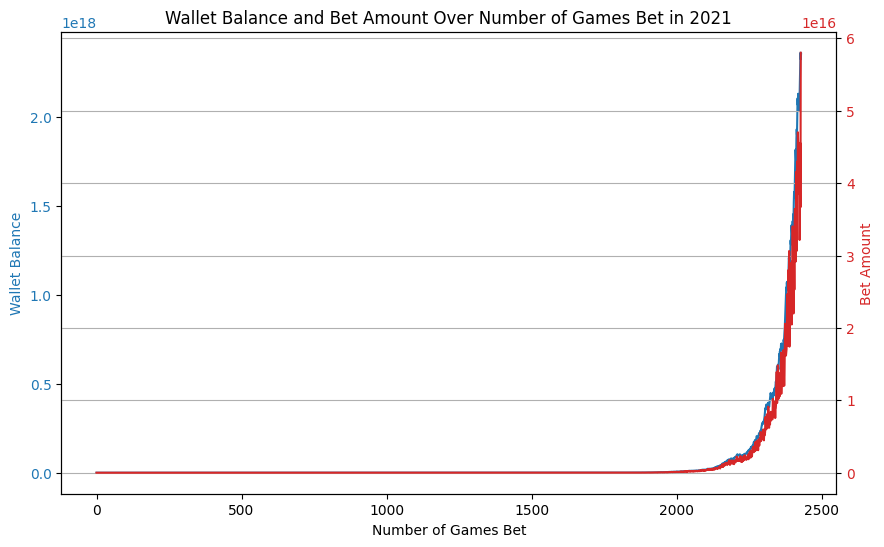

5.800875208158677e+16
15.690819025039673
940.0437343120575
2.356976823087554e+18


In [150]:
plot_wallet_balance(better, test_year)
print(max(better.bet_history))
print(min(better.bet_history))
print(min(better.wallet_history))
print(better.wallet_history[-1])


In [151]:
view_data(per_game_finished)

There are no NaN values in the dataset


In [152]:
# view_data(pitcher_names)
view_data(batter_data)



    #return missing_player_ids_train, missing_player_ids_val, missing_player_ids_test, avg_class_report, avg_conf_matrix, better.bet_history, better.wallet_history


The column player_ID has 4.4% NaN values.
The column age has 1.2% NaN values.
The column mlb_ID has 7.0% NaN values.
The column lg_ID has 0.6% NaN values.
The column PA has 0.7% NaN values.
The column Inn has 37.5% NaN values.
The column runs_infield has 37.5% NaN values.
The column runs_outfield has 37.5% NaN values.
The column runs_catcher has 37.5% NaN values.
The column runs_good_plays has 76.7% NaN values.
The column runs_position has 0.8% NaN values.
The column runs_replacement has 0.7% NaN values.
The column runs_above_rep has 0.8% NaN values.
The column runs_above_avg has 0.8% NaN values.
The column runs_above_avg_off has 0.8% NaN values.
The column runs_above_avg_def has 0.8% NaN values.
The column WAA has 7.9% NaN values.
The column WAA_off has 7.9% NaN values.
The column WAA_def has 7.9% NaN values.
The column WAR has 8.9% NaN values.
The column WAR_def has 7.9% NaN values.
The column WAR_off has 8.9% NaN values.
The column WAR_rep has 8.7% NaN values.
The column salary has 